# Combination Technique

This notebook demonstrates the basic usage of the combigrid module of SG++.
It shows:
- how to initialize combination technique grid
- how to hierarchize using the unidirectional principle
- how to evaluate the resulting combined grid

Note: If you want to run these introductory notebooks interactively in your browser, you can use Google Colab. See [the according Wiki page](https://github.com/SGpp/SGpp/wiki/Installing-pysgpp-on-colab) for more instructions.

Import the necessary modules. The python bindings for SG++ are called "pysgpp".

In [1]:
%matplotlib notebook
from __future__ import print_function
from pysgpp import *
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

Define a helper function for plotting the interpolant.

In [2]:
def plotFunction(opEval, surpluses, X):
  # generate a meshgrid for plotting
  xx0 = np.linspace(0, 1, 65)
  xx1 = np.linspace(0, 1, 65)
  XX0, XX1 = np.meshgrid(xx0, xx1)
  XX = DataMatrix(np.column_stack([XX0.flatten(), XX1.flatten()]))
  # evaluate interpolant at meshgrid
  YY = DataVector(0)
  opEval.multiEval(surpluses, XX, YY)
  # convert resulting sgpp::base::DataVector to NumPy array
  YY = np.reshape(np.array([YY[k] for k in range(YY.getSize())]), XX0.shape)
  fig = plt.figure(figsize=(6, 6))
  ax = fig.gca(projection="3d")
  ax.plot_surface(XX0, XX1, YY)
  ax.plot(X[:,0], X[:,1], "k.", zs=f(X[:,0], X[:,1]), ms=10)

Define a simple two dimensional objective function

<IPython.core.display.Javascript object>


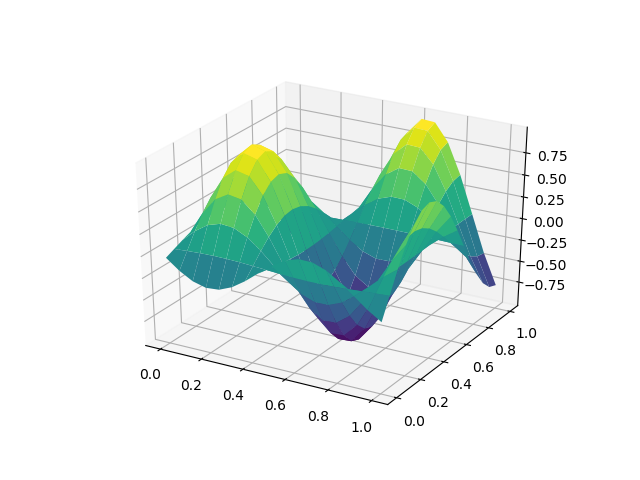

In [3]:
f = lambda x1, x2: np.sin(7*x1-3)*np.cos(5*x2-5)
# and plot
XX = np.linspace(0,1,17)
(X, Y) = np.meshgrid(XX, XX)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, f(X, Y), rstride=1, cstride=1, cmap='viridis')

Define parameters

In [4]:
dim = 2
# regular level of sparse grid
n = 4
# B-spline degree
p = 3
# whether there are points on the boundary
hasBoundary = True
# disable log output
Printer.getInstance().setVerbosity(-1)

The basis functions are defined via an sgpp::combigrid::HeterogeneousBasis object. In contrast
 to sgpp::base::Basis, this allows for different types of basis functions for the different
 dimensions. However, for this example, we do not need this flexibility, so we use the same
 basis function types for both dimensions.

In [5]:
basis1d = SBsplineBase(p)
basis = HeterogeneousBasis(dim, basis1d)

A `CombinationGrid` is a collection of full grids (nodal subspaces) together with scalar-valued coefficients. Construct such a `CombinationGrid` object for a regular sparse grid via the combination technique.

In [6]:
combiGrid = CombinationGrid.fromRegularSparse(dim, n, basis, hasBoundary)

We obtain the grid points of the regular sparse grid by combining the grid points of all full grids that are contained in the combination grid.

In [7]:
gridStorage = HashGridStorage(dim)
combiGrid.combinePoints(gridStorage)

Convert the grid storage to an array with coordinates of grid points and evaluate test function at grid points

In [8]:
X = np.array([[gridStorage.getPoint(k).getStandardCoordinate(d) for d in range(dim)]
              for k in range(gridStorage.getSize())])
fX = DataVector(f(X[:,0], X[:,1]))

We now want to perform an operation on each full grid. For this, we distribute the values of the combined grid (sparse grid) to the full grids. The result is a `std::vector` of `DataVector`; each `DataVector` contains the values at all grid points for one specific full grid.

In [9]:
values = DataVectorVector()
combiGrid.distributeValuesToFullGrids(gridStorage, fX, values)

The operation we want to perform on each full grid is hierarchization. Since the grids are
 full grids, we can use the unidirectional principle for this, which performs 1D hierarchization
 on each pole (= a one-dimensional sub-grid), iterating over all dimensions.

Create pole operation, create operation for unidirectional principle and hierarchize in-place

In [11]:
# copy the values (surpluses will be modified in-place)
surpluses = DataVectorVector(values)
opPole = OperationPoleVector()
#fill the vector opPole with OperationPoleHierarchisation
OperationPoleHierarchisationGeneral.fromHeterogenerousBasis(basis, opPole)
opHier = OperationUPCombinationGrid(combiGrid, opPole)
opHier.apply(surpluses)

The resulting surpluses are also a `std::vector` of `DataVector`, separated by full grids. We could combine the full grid surpluses via the combination formula to the sparse grid surpluses via `combineSparseGridValues`. However, the operation `OperationEvalCombinationGrid` does this automatically.  

We evaluate the combined function (combination of all full grid interpolants) at some arbitrary point, print the value, and plot the function.

Value of test function at [0.12 0.34]: 0.820974
Value of combined sparse grid interpolant at [0.12 0.34]: 0.774666


<IPython.core.display.Javascript object>


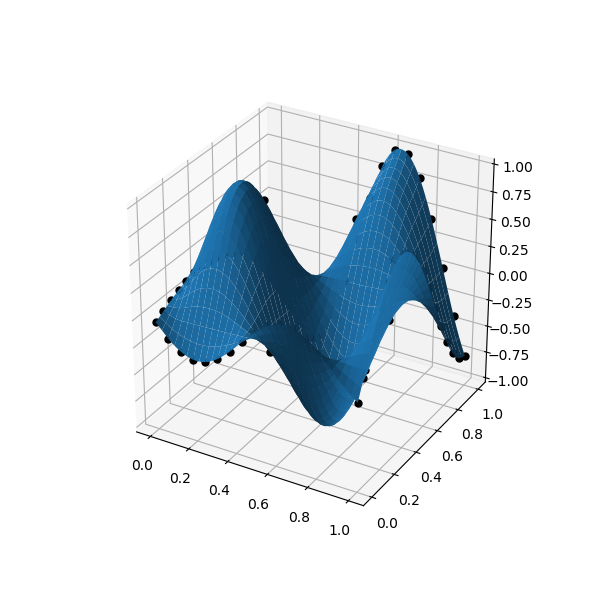

In [12]:
x = [0.12, 0.34]
xDv =DataVector(x)
print("Value of test function at {}: {:.6g}".format(np.array(x), f(*x)))
# create operation for evaluating and evaluate
opEval = OperationEvalCombinationGrid(combiGrid)
y = opEval.eval(surpluses, xDv)
print("Value of combined sparse grid interpolant at {}: {:.6g}".format(np.array(x), y))
# plot
plotFunction(opEval, surpluses, X)

Finally, we do the same for one full grid of the combination grid: We evaluate and plot the
corresponding interpolant. We extract the surpluses from the already calculated \c vector of
 \c DataVector. Alternatively, we could also apply sgpp::combigrid::OperationUPFullGrid with
 opPole to obtain the surpluses for this single full grid.
select the second full grid of the combination grid (arbitrary choice)

Level of selected full grid with index 1: [3 1]
Value of full grid interpolant at [0.12 0.34]: 0.564036


<IPython.core.display.Javascript object>


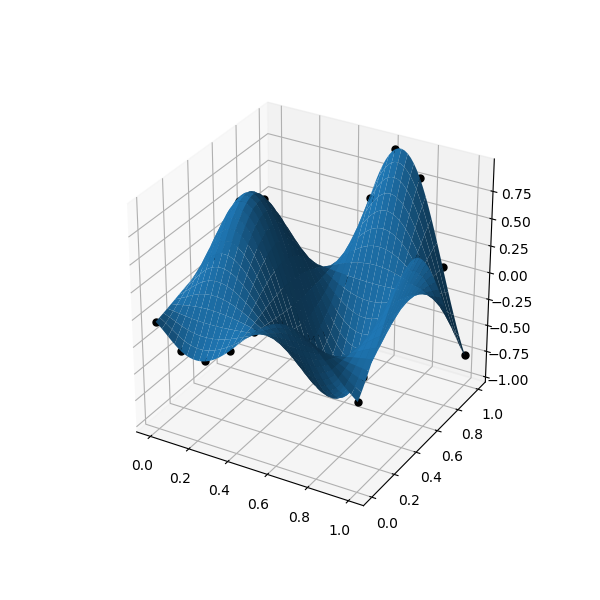

In [13]:
fullGridIndex = 1
fullGrid = combiGrid.getFullGrids()[fullGridIndex]
l = fullGrid.getLevel()
print("Level of selected full grid with index {}: {}".format(fullGridIndex, np.array(l)))

# create operation for evaluating and evaluate
opEval = OperationEvalFullGrid(fullGrid)
y = opEval.eval(surpluses[fullGridIndex], xDv)
print("Value of full grid interpolant at {}: {:.6g}".format(np.array(x), y))

# compute grid points of full grid
X = DataMatrix(0, 0)
IndexVectorRange.getPoints(fullGrid, X)

# convert resulting sgpp::base::DataMatrix to NumPy array
X = np.array([[X.get(k, j) for j in range(X.getNcols())] for k in range(X.getNrows())])

# plot
plotFunction(opEval, surpluses[fullGridIndex], X)

We see that the value of the combined sparse grid interpolant at the evaluation point is
closer to the actual value of the test function than the value of the chosen full grid
interpolant, which corresponds to the full grid of level $(3, 1)$.